<a href="https://www.kaggle.com/jaimemorillo/genre-prediction?scriptVersionId=86393507" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [4]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
import tensorflow as tf
from tqdm.notebook import tqdm
tqdm.pandas()
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

In [5]:
tmdb_df = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv', index_col='id')

# Preprocessing

In [6]:
tmdb_df = tmdb_df.loc[:,['overview','genres']]
tmdb_df = tmdb_df.dropna(subset=['overview', 'genres'])

def parse_genres(genres_string):
    genres_dict = eval(genres_string)
    genres = [i['name'] for i in genres_dict]
    return genres

tmdb_df['genres'] = tmdb_df['genres'].progress_apply(lambda x: parse_genres(x))
df = tmdb_df.copy()

  0%|          | 0/4800 [00:00<?, ?it/s]

Mapping the genres to combine them

In [7]:
mlb = MultiLabelBinarizer()
genres_binary = mlb.fit_transform(df['genres'])
genres = pd.DataFrame(genres_binary, columns=mlb.classes_, index=df.index)

In [8]:
df = df.join(genres).drop(['genres', 'Foreign', 'History', 'Music', 'Animation',
                           'War', 'Western', 'TV Movie', 'Documentary'], axis=1)
df = df[df.sum(axis=1)!=0] # Remove movies with no genres
# Remove multiple white spaces
df['overview'] = df['overview'].progress_apply(lambda x: re.sub(' +', ' ', x))
df.reset_index(inplace=True, drop=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  This is separate from the ipykernel package so we can avoid doing imports until


  0%|          | 0/4660 [00:00<?, ?it/s]

### Genres distribution

(4660, 13)


Text(0, 0.5, 'Genres')

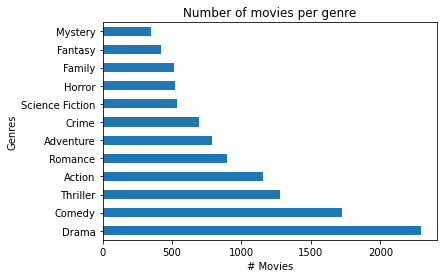

In [9]:
print(df.shape)
ax = df.iloc[:,1:].sum().sort_values(ascending=False).plot(kind='barh',
                                                           title='Number of movies per genre')
ax.set_xlabel("# Movies")
ax.set_ylabel("Genres")

### Number of genres per movie

count    4660.00
mean        2.40
std         1.06
min         1.00
25%         2.00
50%         2.00
75%         3.00
max         7.00
dtype: float64


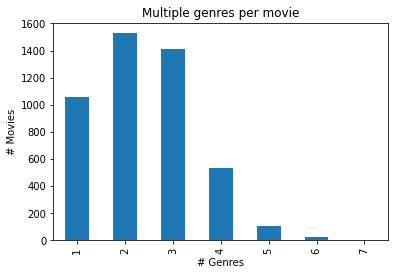

In [10]:
sum_df = df.iloc[:,1:].sum(axis=1)
ax = sum_df.value_counts().sort_index().plot(kind='bar', title='Multiple genres per movie')
ax.set_xlabel('# Genres')
ax.set_ylabel('# Movies')
print(sum_df.describe().round(2))

### Number of characters

count    4660.0
mean      304.1
std       159.9
min         1.0
25%       178.0
50%       284.0
75%       391.0
max      1000.0
Name: overview, dtype: float64


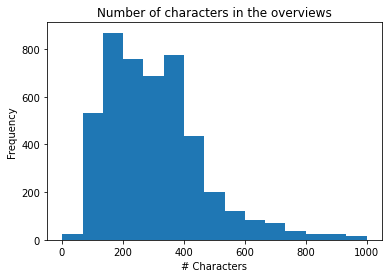

In [11]:
chr_lens = df.overview.str.len()
ax = chr_lens.plot(kind='hist', bins=15, title='Number of characters in the overviews')
ax.set_xlabel("# Characters")
print(chr_lens.describe().round(2))

### Number of words

count    4660.00
mean       51.99
std        27.44
min         2.00
25%        30.00
50%        48.00
75%        67.00
max       175.00
Name: overview, dtype: float64


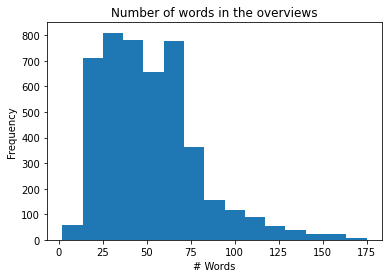

In [12]:
word_lens = df.overview.str.split(" ").str.len()
ax = word_lens.plot(kind='hist', bins=15, title='Number of words in the overviews')
ax.set_xlabel("# Words")
print(word_lens.describe().round(2))

In [14]:
df_final = df.copy()
df_final.shape

(4660, 13)

# Naive Bayes

In [15]:
stop_words = set(stopwords.words('english')) # Stop words
porter = PorterStemmer() # Stemmer

def clean(text):
    text = text.lower() # To lower case
    # Replace contractions
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text) # Replace any character which is not a word character
    text = re.sub('\s+', ' ', text) # Replace any whitespace character
    text = re.sub(' +', ' ', text) # Replace multiple whitespaces
    text = text.strip() # Delete sorrounding whitespaces
    tokens = word_tokenize(text) # Tokenize text
    #  Delete Stop Words and apply stemming
    new_tokens = [porter.stem(word) for word in tokens if not word in stop_words] 
    text = (" ").join(new_tokens) # Join tokens
    return text

df_final['overview'] = df_final['overview'].progress_apply(lambda x: clean(x))

  0%|          | 0/4660 [00:00<?, ?it/s]

In [16]:
print('Og: ' + df['overview'][5])
print('New: ' + df_final['overview'][5])

Og: The seemingly invincible Spider-Man goes up against an all-new crop of villain – including the shape-shifting Sandman. While Spider-Man’s superpowers are altered by an alien organism, his alter ego, Peter Parker, deals with nemesis Eddie Brock and also gets caught up in a love triangle.
New: seemingli invinc spider man goe new crop villain includ shape shift sandman spider man superpow alter alien organ alter ego peter parker deal nemesi eddi brock also get caught love triangl


In [17]:
X = df_final.overview
y = df_final.drop(['overview'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
print(X_train.shape)
print(X_test.shape)

(3728,)
(932,)


Tf-Idf strategy

In [27]:
# Ignore words that appear in less than 10 document and more than 80% of the documents
tfidf = TfidfVectorizer(stop_words=stop_words, max_df=0.8, min_df=10)
X_train_enc = tfidf.fit_transform(X_train)
X_test_enc = tfidf.transform(X_test)

print('Vocabulary: ' + str(X_train_enc.shape[1]))
print('Og: ' + X_train[3])
print('Encoded: ' + str(X_train_enc[3]))

Vocabulary: 1998
Og: follow death district attorney harvey dent batman assum respons dent crime protect late attorney reput subsequ hunt gotham citi polic depart eight year later batman encount mysteri selina kyle villain bane new terrorist leader overwhelm gotham finest dark knight resurfac protect citi brand enemi
Encoded:   (0, 284)	0.22446153666179
  (0, 1339)	0.19611956108213768
  (0, 1980)	0.2700910624196864
  (0, 134)	0.23393504951992836
  (0, 315)	0.28999650344792005
  (0, 91)	0.2721398055734086
  (0, 516)	0.23136888472044098
  (0, 507)	0.2841157761370443
  (0, 1493)	0.2549877633045189
  (0, 883)	0.26813340520493745
  (0, 590)	0.185552125002688
  (0, 1338)	0.30061728906241525
  (0, 997)	0.17952484169701424
  (0, 1755)	0.17727868737331992
  (0, 735)	0.25223436454517495
  (0, 354)	0.24161357893067972
  (0, 760)	0.20903860913422861


Naive Bayes (One vs Rest / Multilabel)

In [28]:
clf = OneVsRestClassifier(MultinomialNB())
clf.fit(X_train_enc, y_train)
y_pred_proba = clf.predict_proba(X_test_enc)
predictions = clf.predict(X_test_enc)

In [29]:
print(sklearn.metrics.label_ranking_average_precision_score(y_test, y_pred_proba))
print(sklearn.metrics.label_ranking_loss(y_test, y_pred_proba))

0.7323576126325592
0.14315376842200875
0.8308894694649402


In [30]:
print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test, predictions)))
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test, y_pred=predictions, average='samples'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test, y_pred=predictions, average='samples')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test, y_pred=predictions, average='samples'))) 

Exact Match Ratio: 0.13197424892703863
Hamming loss: 0.15736766809728184
Recall: 0.532725321888412
Precision: 0.3580472103004292
F1 Measure: 0.39981861843449823


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(y_test, predictions)
for idx,i in enumerate(confusion_matrix):
    print(y_test.columns[idx] + ' ----------------------------------------------------------------------')
    print('Acc: {0}'.format(sklearn.metrics.accuracy_score(y_test.iloc[:,idx], 
                                                           pd.DataFrame(predictions).iloc[:,idx])))
    print('F1-score: {0}'.format(sklearn.metrics.f1_score(y_test.iloc[:,idx], 
                                                          pd.DataFrame(predictions).iloc[:,idx])))
    print(i)

Action ----------------------------------------------------------------------
Acc: 0.8261802575107297
F1-score: 0.4807692307692308
[[695  19]
 [143  75]]
Adventure ----------------------------------------------------------------------
Acc: 0.8465665236051502
F1-score: 0.17341040462427745
[[774   4]
 [139  15]]
Comedy ----------------------------------------------------------------------
Acc: 0.7542918454935622
F1-score: 0.560460652591171
[[557  45]
 [184 146]]
Crime ----------------------------------------------------------------------
Acc: 0.8701716738197425
F1-score: 0.1768707482993197
[[798   2]
 [119  13]]
Drama ----------------------------------------------------------------------
Acc: 0.7178111587982833
F1-score: 0.7093922651933701
[[348 131]
 [132 321]]
Family ----------------------------------------------------------------------
Acc: 0.9012875536480687
F1-score: 0.0
[[840   0]
 [ 92   0]]
Fantasy ----------------------------------------------------------------------
Acc: 0.9206

# DistilBert

In [44]:
X = df.overview
y = df.drop(['overview'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)

In [45]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Example

In [46]:
text = X_train.iloc[0]
encoded_input = tokenizer(text)

print('Original text: '+ text)
print('Tokens: ' + str(encoded_input))
print('Reverse tokens: ' + tokenizer.decode(encoded_input["input_ids"]))

Original text: Special Agent Strahm is dead, and Detective Hoffman has emerged as the unchallenged successor to Jigsaw's legacy. However, when the FBI draws closer to Hoffman, he is forced to set a game into motion, and Jigsaw's grand scheme is finally understood.
Tokens: {'input_ids': [101, 2569, 4005, 2358, 10404, 2213, 2003, 2757, 1010, 1998, 6317, 15107, 2038, 6003, 2004, 1996, 4895, 18598, 7770, 5999, 6332, 2000, 10147, 5620, 10376, 1005, 1055, 8027, 1012, 2174, 1010, 2043, 1996, 8495, 9891, 3553, 2000, 15107, 1010, 2002, 2003, 3140, 2000, 2275, 1037, 2208, 2046, 4367, 1010, 1998, 10147, 5620, 10376, 1005, 1055, 2882, 5679, 2003, 2633, 5319, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Reverse tokens: [CLS] special agent strahm is dead, and detective hoffman has emerged as the unchallenged successor to jigsaw's

In [47]:
batch_sentences = X_train.values.tolist()
X_train = tokenizer(batch_sentences, padding=True, 
                    truncation=True, return_tensors="tf")
X_train['targets'] = np.array(y_train)
max_length = X_train['input_ids'].shape[1]

batch_sentences = X_test.values.tolist()
X_test = tokenizer(batch_sentences, padding='max_length', max_length=max_length, 
                   truncation=True, return_tensors="tf")
X_test['targets'] = np.array(y_test)

print(X_train)
print(tokenizer.decode(X_train["input_ids"][0]))

{'input_ids': <tf.Tensor: shape=(3728, 225), dtype=int32, numpy=
array([[ 101, 2569, 4005, ...,    0,    0,    0],
       [ 101, 2275, 1999, ...,    0,    0,    0],
       [ 101, 1037, 2732, ...,    0,    0,    0],
       ...,
       [ 101, 1996, 4251, ...,    0,    0,    0],
       [ 101, 1999, 3381, ...,    0,    0,    0],
       [ 101, 8057, 1010, ...,    0,    0,    0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(3728, 225), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'targets': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])}
[CLS] special agent strahm is dead, and detective hoffman has emerged as the unchallenged successor t

In [50]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                              num_labels=len(y_train.columns), 
                                                              problem_type="multi_label_classification")

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

2022-01-28 12:53:34.001108: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint 

In [51]:
train_features = {x: X_train[x] for x in tokenizer.model_input_names}
train_tf_dataset = tf.data.Dataset.from_tensor_slices((train_features, X_train["targets"]))
train_tf_dataset = train_tf_dataset.shuffle(len(X_train)).batch(32)

test_features = {x: X_test[x] for x in tokenizer.model_input_names}
test_tf_dataset = tf.data.Dataset.from_tensor_slices((test_features, X_test["targets"]))
test_tf_dataset = test_tf_dataset.batch(32)

In [52]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=tf.keras.metrics.TopKCategoricalAccuracy(k=3)
)

model.fit(train_tf_dataset, validation_data=test_tf_dataset, epochs=3)

Epoch 1/3
117/117 [==============================] - 66s 474ms/step - loss: 0.4270 - top_k_categorical_accuracy: 0.6703 - val_loss: 0.3413 - val_top_k_categorical_accuracy: 0.7682
Epoch 2/3
117/117 [==============================] - 54s 463ms/step - loss: 0.3106 - top_k_categorical_accuracy: 0.8085 - val_loss: 0.3130 - val_top_k_categorical_accuracy: 0.7961
Epoch 3/3
117/117 [==============================] - 54s 463ms/step - loss: 0.2496 - top_k_categorical_accuracy: 0.8560 - val_loss: 0.3135 - val_top_k_categorical_accuracy: 0.8079


In [53]:
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

y_pred_logits = model.predict(test_tf_dataset)
y_pred_proba = inv_logit(y_pred_logits[0])

predictions = pd.DataFrame(y_pred_proba, columns=y_test.columns, index=y_test.index).copy()
predictions[predictions>=0.5] = 1
predictions[predictions<0.5] = 0

Logits to labels 
https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow

Probability of 0.5 corresponds to a logit of 0. Negative logit correspond to probabilities less than 0.5, positive to > 0.5.

In [54]:
y_test

,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
3454,0,0,1,0,0,0,0,0,0,0,0,0
3574,0,0,0,0,0,0,0,1,0,0,0,1
1480,0,0,0,0,0,0,0,0,1,0,0,1
1902,0,0,0,0,0,0,0,1,0,0,0,1
2030,0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4411,0,0,0,0,0,0,0,1,1,0,0,0
2568,0,0,0,0,0,0,0,1,1,0,1,0
910,1,0,1,0,0,0,0,0,0,0,0,0
2339,0,0,0,0,1,0,0,0,0,0,0,0


In [55]:
predictions

,Action,Adventure,Comedy,Crime,Drama,Family,Fantasy,Horror,Mystery,Romance,Science Fiction,Thriller
3454,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1480,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1902,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2030,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
4411,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2568,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
910,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2339,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

https://stackoverflow.com/questions/31311154/explanation-for-coverage-error-metric-in-scikit-learn

https://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics

In [56]:
print(sklearn.metrics.label_ranking_average_precision_score(y_test, y_pred_proba))
print(sklearn.metrics.label_ranking_loss(y_test, y_pred_proba))

0.7949706387139334
0.10190736753907355
0.8704258783463351


In [57]:
print('Exact Match Ratio: {0}'.format(sklearn.metrics.accuracy_score(y_test, predictions)))
print('Recall: {0}'.format(sklearn.metrics.precision_score(y_true=y_test, y_pred=predictions, average='samples'))) 
print('Precision: {0}'.format(sklearn.metrics.recall_score(y_true=y_test, y_pred=predictions, average='samples')))
print('F1 Measure: {0}'.format(sklearn.metrics.f1_score(y_true=y_test, y_pred=predictions, average='samples'))) 

Exact Match Ratio: 0.20815450643776823
Hamming loss: 0.13394134477825465
Recall: 0.6992310443490701
Precision: 0.6503934191702432
F1 Measure: 0.6340375706792015


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [58]:
confusion_matrix = sklearn.metrics.multilabel_confusion_matrix(y_test, predictions)
for idx,i in enumerate(confusion_matrix):
    print(y_test.columns[idx] + ' ----------------------------------------------------------------------')
    print('Acc: {0}'.format(sklearn.metrics.accuracy_score(y_test.iloc[:,idx], predictions.iloc[:,idx])))
    print('F1-score: {0}'.format(sklearn.metrics.f1_score(y_test.iloc[:,idx], predictions.iloc[:,idx])))
    print(i)

Action ----------------------------------------------------------------------
Acc: 0.8412017167381974
F1-score: 0.6890756302521008
[[620  94]
 [ 54 164]]
Adventure ----------------------------------------------------------------------
Acc: 0.8648068669527897
F1-score: 0.5298507462686567
[[735  43]
 [ 83  71]]
Comedy ----------------------------------------------------------------------
Acc: 0.8015021459227468
F1-score: 0.6911519198664441
[[540  62]
 [123 207]]
Crime ----------------------------------------------------------------------
Acc: 0.8776824034334764
F1-score: 0.5581395348837208
[[746  54]
 [ 60  72]]
Drama ----------------------------------------------------------------------
Acc: 0.7371244635193133
F1-score: 0.7502548419979613
[[319 160]
 [ 85 368]]
Family ----------------------------------------------------------------------
Acc: 0.9356223175965666
F1-score: 0.5714285714285714
[[832   8]
 [ 52  40]]
Fantasy -------------------------------------------------------------------